In [1]:
import numpy as np
from astropy.time import Time
import astropy.units as u
from gammapy.data import EventList, GTI, Observations, FixedPointingInfo
from gammapy.irf import IRF, load_irf_dict_from_file
from ctao_data_model import IRFGroup, IRFGroups, VODFObservation, DatasetsArray
from gammapy.makers import MapDatasetMaker
from gammapy.datasets import MapDataset, Datasets
from gammapy.maps import WcsGeom, MapAxis, Map, LabelMapAxis

In [2]:
events = EventList.read("$GAMMAPY_DATA/cta-1dc/data/baseline/gps/gps_baseline_111140.fits")
gti = GTI.read("$GAMMAPY_DATA/cta-1dc/data/baseline/gps/gps_baseline_111140.fits")

#### Create 2 SOIs with 2 event types. This results in 4 IRF groups.

In [3]:
time_range1 = GTI.from_time_intervals([gti.time_start + [0, 5]*u.min])
time_range2 = GTI.from_time_intervals([gti.time_stop - [10, 0]*u.min])

In [4]:
irf_dict = load_irf_dict_from_file("$GAMMAPY_DATA/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz")
group1A = IRFGroup(gti=time_range1, event_type=1, **irf_dict)
group1B = IRFGroup(gti=time_range1, event_type=2, **irf_dict)

group2A = IRFGroup(gti=time_range2, event_type=1, **irf_dict)
group2B = IRFGroup(gti=time_range2, event_type=2, **irf_dict)

grps = IRFGroups([group1A, group1B, group2A, group2B])

#### Add the event types on the event list

In [5]:
events.table["event_type"] = np.random.choice([1, 2], size=len(events.table))

#### Create the observation object

In [6]:
pointing = FixedPointingInfo.from_fits_header(events.table.meta)

observation = VODFObservation(obs_id=1, irf_groups=grps, gti=gti, events=events, pointing=pointing)

In [7]:
# This replaces Observations 
observation_blocks = [observation]

#### Prepare the data reduction

In [17]:
energy_axis = MapAxis.from_energy_bounds(0.1,10,10, unit="TeV")
energy_axis_true = MapAxis.from_energy_bounds(0.1,10, 10, unit="TeV", name="energy_true")

geom = WcsGeom.create(skydir=(0,0), width="6 deg", frame="galactic", proj="CAR", binsz=0.02, 
                        axes=[energy_axis])

In [9]:
event_type_axis = MapAxis.from_nodes([1, 2], name="event_type")

empty = MapDataset.create(geom, energy_axis_true, name="dataset")
datasets = DatasetsArray.create(empty, event_type_axis)

In [10]:
maker = MapDatasetMaker()

In [11]:
offset_max = 5*u.deg

for ob in observation_blocks:
    for event_type in [1, 2]:
        for obs in observation.split(event_type): 
            stacked = datasets.get_by_coord({"event_type":event_type})
            # First a cutout of the target map is produced
            cutout = stacked.cutout(
                    obs.get_pointing_icrs(obs.tmid), width=2 * offset_max, name=f"obs-{obs.obs_id}"
            )
    
            dataset = maker.run(cutout, obs)
            stacked.stack(dataset)


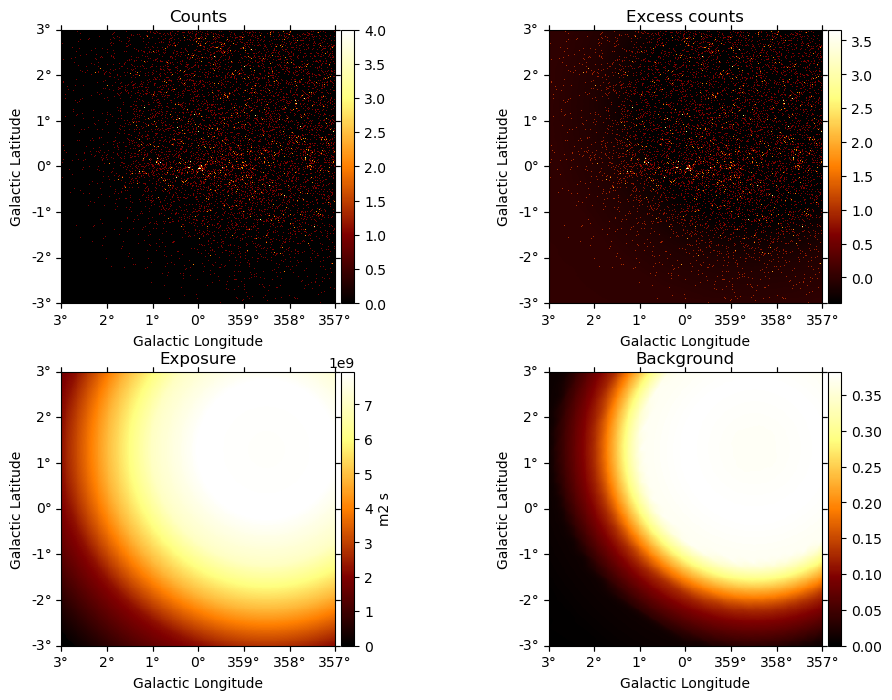

In [16]:
datasets.datasets[1].peek()

In [19]:
datasets._axes.get_coord()

{'event_type': <Quantity [1., 2.]>}